In [22]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import r2_score

In [23]:
df = pd.read_csv("Datas/data_rudy.csv")

In [24]:
df.head(1)

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count,day,month,day_number,year,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16,Saturday,1,0,2011,0


## Train Test Split

In [ ]:
# Split des données avant (train) et après(test) Septembre 2012

In [25]:
X_train = df[(df.month <=  8) | (df.year == 2011)].drop(["datetime","count"], axis=1)
X_test = df[(df.month >  8) & (df.year == 2012)].drop(["datetime","count"], axis=1)
y_train = np.log1p(df[(df.month <=  8) | (df.year == 2011)]["count"])
y_test = np.log1p(df[(df.month >  8) & (df.year == 2012)]["count"])

## Pipelines

In [26]:
one_hot_features = ["weather", "holiday", "workingday", "season", "month", "day", "year"]
standard_feature = ["temp", "humidity", "windspeed", "day_number", "hour"]

one_hot_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
standard_pipeline = make_pipeline(StandardScaler())

processor = make_column_transformer((one_hot_pipeline, one_hot_features), (standard_pipeline, standard_feature))

In [27]:
rfr = make_pipeline(processor, RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='squared_error',
                      max_depth=10, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0, min_samples_leaf=6,
                      min_samples_split=9, min_weight_fraction_leaf=0.0,
                      n_estimators=150, random_state=1))
                      
lgbm = make_pipeline(processor, LGBMRegressor())

## Scoring des modèle

In [36]:
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print(rfr.score(X_test, y_test))

print("Score R2 :", r2_score(y_test, y_pred))

0.7247767401632359
Score R2 : 0.7247767401632359


In [29]:
lgbm.fit(X_train, y_train)
yl_pred = lgbm.predict(X_test)
print(lgbm.score(X_test, y_test))

print("Score R2 :", r2_score(y_test, yl_pred))

0.948016894587881
Score R2 : 0.948016894587881


In [30]:
from sklearn.model_selection import learning_curve

In [31]:
train_size, train_score, val_score = learning_curve(rfr, X_train, y_train, train_sizes=np.linspace(0.1,1,50), scoring="r2")

plt.plot(train_size, train_score.mean(axis=1))
plt.plot(train_size, val_score.mean(axis=1))

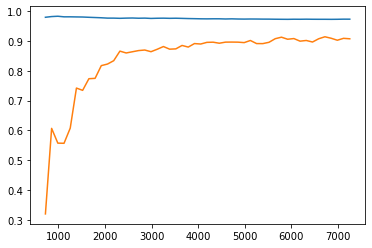

In [32]:
train_size, train_score, val_score = learning_curve(lgbm, X_train, y_train, train_sizes=np.linspace(0.1,1,50))

plt.plot(train_size, train_score.mean(axis=1))
plt.plot(train_size, val_score.mean(axis=1))

## Test de toutes les métriques

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error

In [39]:
def metrics(y_test, y_pred):
    print("r2 :", r2_score(y_test,y_pred))
    print("MAE :", mean_absolute_error(np.exp(y_test),np.exp(y_pred)))
    print("MSE :", mean_squared_error(np.exp(y_test),np.exp(y_pred)))
    print("MeAE :", median_absolute_error(np.exp(y_test),np.exp(y_pred)))

In [50]:
print("         RFR :")
metrics(y_test=y_test, y_pred=y_pred)

         RFR :
r2 : 0.7247767401632359
MAE : 120.7623719069108
MSE : 36383.27398641483
MeAE : 55.53945366802648


In [51]:
print("         LGBM :")
metrics(y_test=y_test, y_pred=yl_pred)

         LGBM :
r2 : 0.948016894587881
MAE : 43.976077195121846
MSE : 5229.002819851781
MeAE : 22.53345571492821


Text(0, 0.5, 'Y prédit')

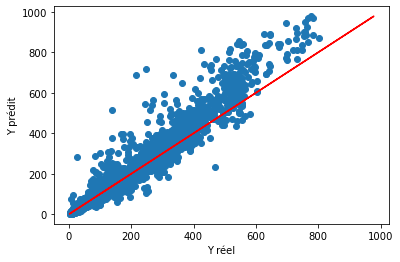

In [64]:
plt.scatter(np.exp(yl_pred), np.exp(y_test))
plt.plot(np.exp(y_test), np.exp(y_test), c="r")
plt.xlabel("Y réel")
plt.ylabel("Y prédit")

In [ ]:
# Le modèle LightGBM a tendance à surévaluer le nombre d'utilisateurs de 45 en moyenne par heure.

In [54]:
print(max(np.exp(yl_pred)-np.exp(y_test)))

236.06612844582838


## Prédictions

In [ ]:
def make_prediction(y, model):
    pred = np.array(y)
    data_pred = pd.DataFrame(pred, columns=list(X_train.columns))
    for col in list(data_pred.columns):
        try:
            data_pred[col] = data_pred[col].astype(float)
        except:
            pass
    return np.exp(model.predict(data_pred))

In [ ]:
print(make_prediction(y=[[4, 1, 0, 1, 25, 30, 20, "Monday", 4, 4370, 2022, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 360, 2011, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 725, 2012, 10]], model=rfr))
                
print(make_prediction(y=[[4, 1, 0, 1, 25, 30, 20, "Monday", 4, 4370, 2022, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 360, 2011, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 725, 2012, 10]],model=lgbm))

[265.88365233 227.81748469 285.7554653 ]
[338.14838561 211.94094152 338.14838561]


## Comparaison des données avec de grands écarts

In [113]:
df_pred = X_test
df_pred["y_reel"] = np.exp(np.array(y_test))
df_pred["y_pred"] = np.exp(yl_pred)
df_pred["Ecart"] = abs(df_pred["y_reel"]- df_pred["y_pred"])

In [116]:
df_pred[df_pred["Ecart"] > 200].describe()

,season,holiday,workingday,weather,temp,humidity,windspeed,month,day_number,year,hour,y_pred,y_reel,Ecart
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.0,56.000000,56.000000,56.000000,56.000000
mean,3.803571,0.035714,0.839286,1.892857,21.466429,70.410714,12.625432,10.250000,655.196429,2012.0,12.982143,424.839891,676.821429,260.412470
std,0.400892,0.187256,0.370591,0.778777,4.804610,17.291907,8.317612,0.958218,29.483074,0.0,4.908216,175.161140,181.669941,60.312067
min,3.000000,0.000000,0.000000,1.000000,12.300000,28.000000,0.000000,9.000000,610.000000,2012.0,0.000000,24.715554,234.000000,200.634316
25%,4.000000,0.000000,1.000000,1.000000,17.835000,57.750000,7.001500,10.000000,640.000000,2012.0,8.000000,270.384534,560.750000,214.592904
50%,4.000000,0.000000,1.000000,2.000000,21.320000,75.000000,11.001400,10.000000,649.000000,2012.0,14.500000,464.568792,722.500000,244.822531
75%,4.000000,0.000000,1.000000,2.250000,25.420000,84.000000,17.498725,11.000000,671.500000,2012.0,17.000000,548.466014,812.000000,286.632244
max,4.000000,1.000000,1.000000,3.000000,31.160000,94.000000,36.997400,12.000000,716.000000,2012.0,21.000000,768.209625,971.000000,471.007702


In [ ]:
# Les valeurs d'humidité sont élevées en moyenne (70.4 %) pour de grands écarts de prédiction.